In [1]:
import matplotlib.pyplot as plt
import numpy as np
from typing import *

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, Operator
from qiskit_aer import AerSimulator
sim = AerSimulator()

from util import zero, one, qft

# Shor's Part 3/5: Modular Exponentiation



References
1. [Introduction to Classical and Quantum Computing, Chapter 7.9.3](https://www.thomaswong.net/introduction-to-classical-and-quantum-computing-1e4p.pdf)
2. [Qiskit notebook on Shor's Algorithm](https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/shor.ipynb)
3. [Introduction to Quantum Information Science: Lecture 19 by Scott Aaronson](https://www.scottaaronson.com/qclec.pdf)
4. [Quantum Computation and Quantum Information: Chapter 5, Nielsen and Chuang](https://www.cambridge.org/highereducation/books/quantum-computation-and-quantum-information/01E10196D0A682A6AEFFEA52D53BE9AE#overview)

## Quantum Oracle for Modular Multiplication

1. Suppose we have a unitary

$$
U_f |y \rangle = |ay \, (\text{mod} \, N) \rangle 
$$

so that $U_f$ encodes modular multiplication by $a$. This oracle will be useful for quantum order finding.

2. Question: why don't we need an xor oracle?

### Example

Consider

$$
f(x) = a^x \, (\text{mod} \, N)
$$

where $a = 7$ and $N = 15$.

Text(0.5, 1.0, 'a=7 and N=15')

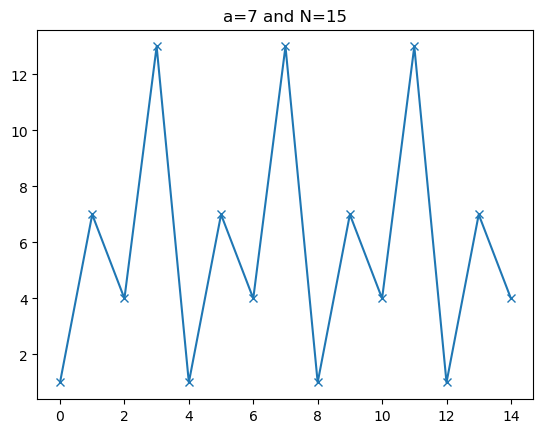

In [2]:
a = 7; N = 15
xs = [x for x in range(N)]
ys = [(a ** x) % N for x in xs]
plt.plot(xs, ys, marker='x'); plt.title("a=7 and N=15")

#### Quantum Oracle

1. Let $y = y_4 y_3 y_2 y_1$ be the binary expansion of $y$ in 4 bits where $y_4$ is the most significant bit.
2. Our goal is to construct the unitary

$$
U_f |y \rangle = |0111 \cdot y \, (\text{mod} \, 1111) \rangle
$$

where $7 = 0111$ and $15 = 1111$.

In [3]:
def amod15(a, power):
    # Adapted From: https://qiskit.org/textbook/ch-algorithms/shor.html
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    U = QuantumCircuit(4)        
    for iteration in range(power):
        if a in [2,13]:
            U.swap(2,3); U.swap(1,2); U.swap(0,1)
        if a in [7,8]:
            U.swap(0,1); U.swap(1,2); U.swap(2,3)
        if a in [4, 11]:
            U.swap(1,3); U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate(); U.name = "%i^%i mod 15" % (a, power); 
    return U

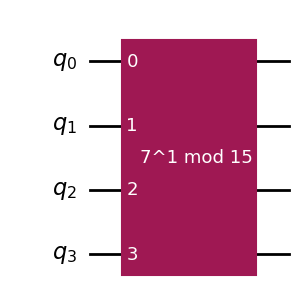

In [4]:
qc_amod15 = QuantumCircuit(4)
qc_amod15.append(amod15(7, 2**0), [0, 1, 2, 3])
U_f = Operator(qc_amod15)
qc_amod15.draw(output="mpl", style="iqp")

In [5]:
print((1 * 7) % 15) # Check that we get binary 7 (little endian)
(zero ^ zero ^ zero ^ one).evolve(U_f).draw("latex")

7


<IPython.core.display.Latex object>

In [6]:
print((3 * 7) % 15) # Check that we get binary 6 (little endian)
(zero ^ zero ^ one ^ one).evolve(U_f).draw("latex")

6


<IPython.core.display.Latex object>

#### Iterating Applications of $U_f$

1. Observe that if we iteratively apply $U_f$ to itself

\begin{align*}
U_f |0001 \rangle & = |a \, (\text{mod} \, N) \rangle \\
U_f^2 |0001 \rangle & = |a^2 \, (\text{mod} \, N) \rangle \\
\vdots & = \vdots \\
U_f^{s-1} |0001 \rangle & = |a^{s-1} \, (\text{mod} \, N) \rangle \\
U_f^{s} |0001 \rangle & = |a^s \, (\text{mod} \, N) \rangle \\
& = |0001 \rangle \,. \\
\end{align*}

2. Thus we can encode the original function as

$$
f(x) = U_f^x |0001\rangle
$$

so that we can sequence $U_f$ $x$ times to simulate $f(x)$.

In [7]:
# Starting vector  (reminder: little endian)
(zero ^ zero ^ zero ^ one).draw("latex")

<IPython.core.display.Latex object>

In [8]:
# U_f |0001>   (reminder: little endian)
(zero ^ zero ^ zero ^ one).evolve(U_f).draw("latex")

<IPython.core.display.Latex object>

In [9]:
U_f2 = U_f.compose(U_f)
# U_f^2 |0001>   (reminder: little endian)
(zero ^ zero ^ zero ^ one).evolve(U_f2).draw("latex")

<IPython.core.display.Latex object>

In [10]:
U_f3 = U_f.compose(U_f2)
# U_f^3 |0001>   (reminder: little endian)
(zero ^ zero ^ zero ^ one).evolve(U_f3).draw("latex")

<IPython.core.display.Latex object>

In [11]:
U_f4 = U_f.compose(U_f3)
# U_f^4 |0011> = |0001>   (reminder: little endian)
# Recall that the order was 4
(zero ^ zero ^ zero ^ one).evolve(U_f4).draw("latex")

<IPython.core.display.Latex object>

#### Aside: Eigenvectors and Eigenvalues

We say that $x$ is an **eigenvector** and $\lambda$ is an **eigenvalue** of a matrix $A$ if

$$
Ax = \lambda x \,.
$$

#### Eigenvectors and eigenvalues of $U_f$

1. $|0001\rangle$ is an eigenvector of $U_f$ with eigenvalue $1$.
2. Are there other eigenvectors/eigenvalues of $U_f$?
3. Let

$$
|u\rangle = \frac{1}{\sqrt{s}} \sum_{k=0}^{s-1} U_f^k |1\rangle
$$

be an equal superposition of the powers of $U_f$. Then

\begin{align*}
U_f |u\rangle & = U_f \left( \frac{1}{\sqrt{s}} \sum_{k=0}^{s-1} U_f^k |1\rangle \right) \tag{definition} \\
& = \left( \frac{1}{\sqrt{s}} \sum_{k=0}^{s-1} U_f^{k+1} |1\rangle \right) \tag{linearity} \\
& = \left( \frac{1}{\sqrt{s}} \sum_{k=0}^{s-1} U_f^{k} |1\rangle \right) \tag{$U_f^0 = U_f^s$} \\
& = |u\rangle \tag{definition}
\end{align*}

In [12]:
(1/2.*((zero ^ zero ^ zero ^ one).evolve(U_f) +
(zero ^ zero ^ zero ^ one).evolve(U_f2) +
(zero ^ zero ^ zero ^ one).evolve(U_f3) +
(zero ^ zero ^ zero ^ one))).draw("latex")

<IPython.core.display.Latex object>

In [13]:
# Checking eigenvector
(1/2.*((zero ^ zero ^ zero ^ one).evolve(U_f) +
(zero ^ zero ^ zero ^ one).evolve(U_f2) +
(zero ^ zero ^ zero ^ one).evolve(U_f3) +
(zero ^ zero ^ zero ^ one))).evolve(U_f).draw("latex")

<IPython.core.display.Latex object>

#### More useful eigenvectors and eigenvalues of $U_f$?

1. It is a fact that unitary matrices have unit norm eigenvalues.
2. Consequently, we might wonder if it possible to have phases $e^{2\pi i k}$ as eigenvalues.
3. Where might we get such eigenvalues? 
4. Let

$$
|u_\ell \rangle = \frac{1}{\sqrt{s}} \sum_{k=0}^{s-1} e^{-\frac{2\pi ik\ell}{s}} U_f^k |1\rangle
$$

be an equal superposition of the powers of $U_f$ with phase shifts $e^{-\frac{2\pi ik\ell}{s}}$ .

5. Then

$$
U_f |u_\ell\rangle = e^{\frac{2\pi i\ell}{s}}|u_\ell\rangle
$$

which means we leak out information about the period $s$ in the global phase.

6. This is the change-of-basis given by the QFT.

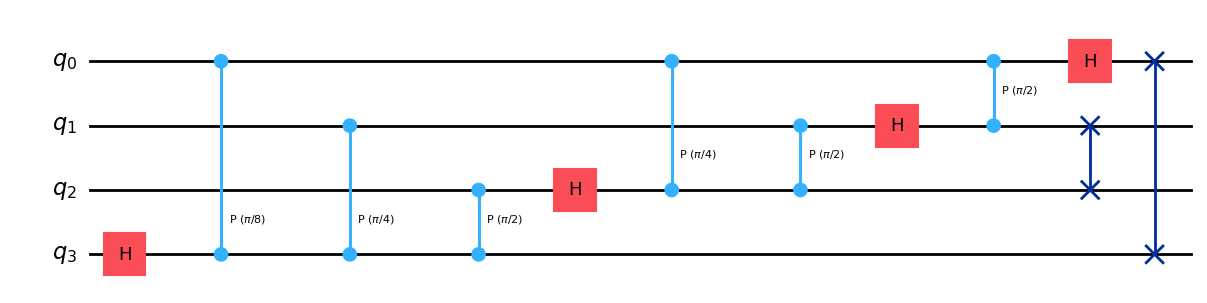

In [14]:
qft4 = QuantumCircuit(4)
qft4 = qft(qft4, 4)
qft4.draw(output="mpl", style="iqp")

In [15]:
(zero ^ zero ^ zero ^ one).evolve(U_f).evolve(qft4).draw("latex")

<IPython.core.display.Latex object>

#### Final fact: Sum of $|u_\ell \rangle$

One final observation is that

$$
|1\rangle = \frac{1}{\sqrt{s}} \sum_{\ell=0}^{s-1} |u_\ell \rangle \,.
$$

## Summary

We reviewed the quantum modular exponentiation algorithm.